In [1]:
#Load packages
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
#import dandelion as ddl
import tables
from rpy2.robjects import r

In [2]:
from collections import defaultdict

In [2]:
#Change working directory
os.chdir("/home/jovyan/data/ClatCov/")


### 2nd round broad annotations 


In [3]:
#load data - one round of broad and fine labelling with scrublet doublets removed. 
adata = sc.read_h5ad('COV_combined_all_fine_label_070721.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 297889 × 1413
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet_score', 'predicted_doublet', 'Sampleid', 'Patient', 'Sampletype', 'Age_group', 'Gender', 'Cohort', 'Diseasetype', 'Batch', 'Study', 'Nasal_inflammation', 'COVID_severity', 'sampleid', 'soup_correction', 'scrublet_score', 'n_genes', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltypist', 'combined_doublet', 'cellbender_cell', 'leiden', 'broad_label', 'fine_label', 'moderate-severe'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Cohort_colors', 'Gender_colors', 'Patient_colors', 'Sampleid_colors', 'Sampletype_colors', 'broad_label_colors', 'celltypist_colors', 'dendrogram_leiden', 'fine_label_colors', 'hvg', 

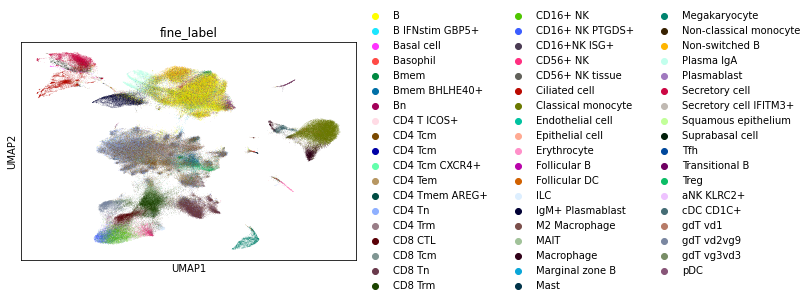

In [5]:
#Visualise
sc.pl.umap(adata, color = 'fine_label')

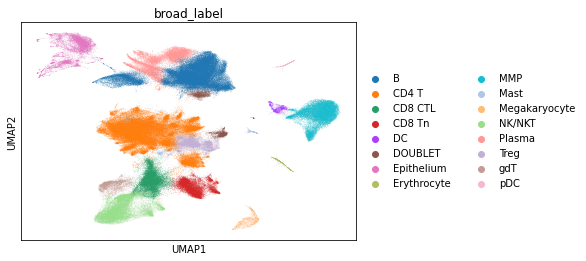

In [6]:
sc.pl.umap(adata, color = 'broad_label')

In [9]:
#remove doublets
adata = adata[adata.obs['broad_label'] != 'DOUBLET']
adata = adata[adata.obs['fine_label'] != 'DOUBLET']
adata

View of AnnData object with n_obs × n_vars = 292189 × 1413
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet_score', 'predicted_doublet', 'Sampleid', 'Patient', 'Sampletype', 'Age_group', 'Gender', 'Cohort', 'Diseasetype', 'Batch', 'Study', 'Nasal_inflammation', 'COVID_severity', 'sampleid', 'soup_correction', 'scrublet_score', 'n_genes', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltypist', 'combined_doublet', 'cellbender_cell', 'leiden', 'broad_label', 'fine_label', 'moderate-severe'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Cohort_colors', 'Gender_colors', 'Patient_colors', 'Sampleid_colors', 'Sampletype_colors', 'celltypist_colors', 'dendrogram_leiden', 'fine_label_colors', 'hvg', 'leiden', 'lei

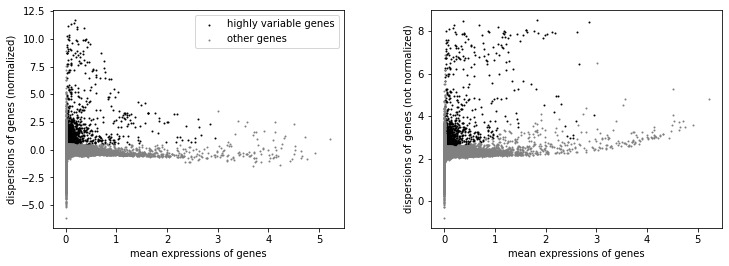

In [11]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# plot highly_variable_genes
sc.pl.highly_variable_genes(adata)

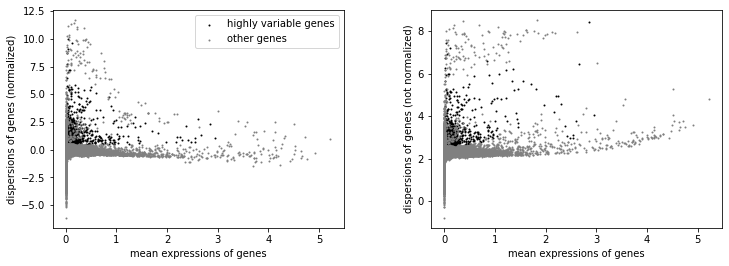

In [12]:
## remove TRBV/TRAV/TRGV/TRDV and IGHV/IGLV/IGKV from the highly variable genes
#Decided not to remove TRGV/TRDV as need these for gdT subset identification. 
import re
for i in adata.var.index:
    if re.search('^TR[AB]V|^IG[HKL]V', i):
        adata.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(adata)

In [13]:
# filter to only highly variable
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 292189 × 1423
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet_score', 'predicted_doublet', 'Sampleid', 'Patient', 'Sampletype', 'Age_group', 'Gender', 'Cohort', 'Diseasetype', 'Batch', 'Study', 'Nasal_inflammation', 'COVID_severity', 'sampleid', 'soup_correction', 'scrublet_score', 'n_genes', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltypist', 'combined_doublet', 'cellbender_cell', 'leiden', 'broad_label', 'fine_label', 'moderate-severe'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [14]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'],n_jobs = multiprocessing.cpu_count()-4)


In [15]:
sc.pp.scale(adata, max_value = 10)


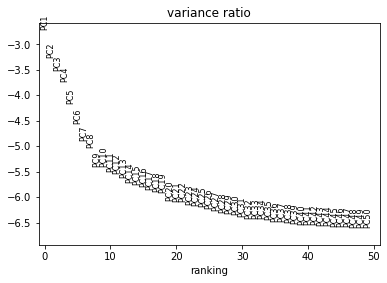

In [16]:
# Principal component analysis
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

In [17]:
# Computing the neighborhood graph. Seurat uses k = 20 as default
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 50)

In [17]:
#What is split between subsets
pd.crosstab(adata.obs['fine_label'],adata.obs['COVID_severity'])

COVID_severity,asymptomatic,mild,mild,moderate,severe
fine_label,,,,,
B,131,12932,6553,472,3076
B IFNstim GBP5+,2,408,212,2,43
Basal cell,0,36,10,35,24
Basophil,20,115,126,21,13
Bmem,12,1236,622,26,248
Bmem BHLHE40+,3,596,216,1,65
CD4 T ICOS+,0,3,0,0,0
CD4 Tcm,12,164,63,0,17
CD4 Tcm,0,29,2,0,5


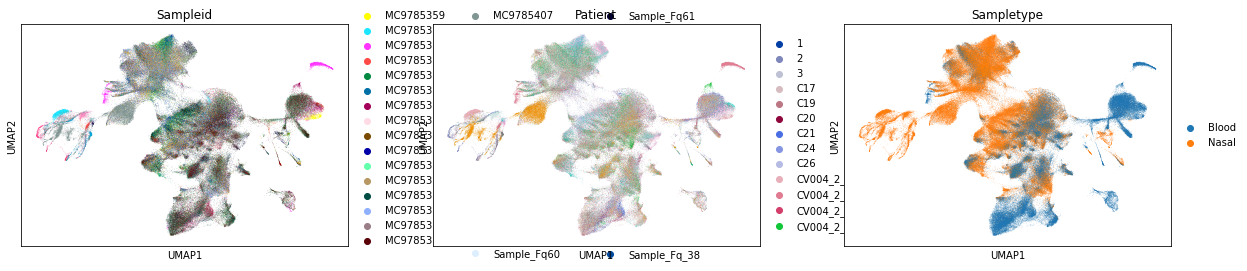

In [18]:
# run UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
sc.pl.umap(adata, color=['Sampleid','Patient', 'Sampletype'])

In [19]:
# run harmony for batch correction 
sc.external.pp.harmony_integrate(adata, 'Patient')
'X_pca_harmony' in adata.obsm


2021-07-12 01:34:43,906 - harmonypy - INFO - Iteration 1 of 10
2021-07-12 01:38:41,685 - harmonypy - INFO - Iteration 2 of 10
2021-07-12 01:42:41,689 - harmonypy - INFO - Iteration 3 of 10
2021-07-12 01:46:38,766 - harmonypy - INFO - Converged after 3 iterations


True

In [20]:
adata

AnnData object with n_obs × n_vars = 292189 × 1423
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet_score', 'predicted_doublet', 'Sampleid', 'Patient', 'Sampletype', 'Age_group', 'Gender', 'Cohort', 'Diseasetype', 'Batch', 'Study', 'Nasal_inflammation', 'COVID_severity', 'sampleid', 'soup_correction', 'scrublet_score', 'n_genes', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltypist', 'combined_doublet', 'cellbender_cell', 'leiden', 'broad_label', 'fine_label', 'moderate-severe'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'Sampleid_colors', 'Patient_colors', 'Sampletype_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connect

In [21]:
# Compute the neighborhood graph with harmony batch correction. Seurat uses k = 20 as default
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 50, use_rep='X_pca_harmony')

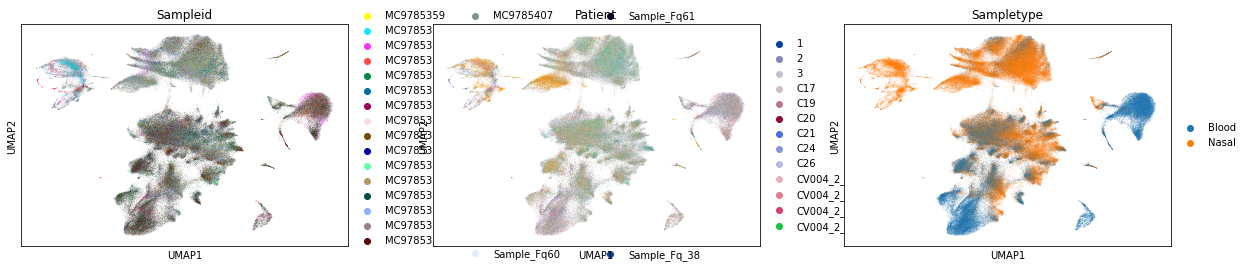

In [22]:
# UMAP with harmony batch correction
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
sc.pl.umap(adata, color=['Sampleid','Patient', 'Sampletype'])

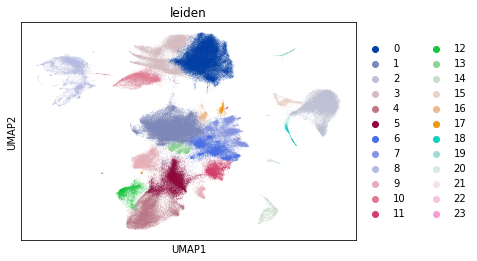

In [23]:
# find broad clusters
sc.tl.leiden(adata, resolution =0.5)
sc.pl.umap(adata, color = 'leiden')

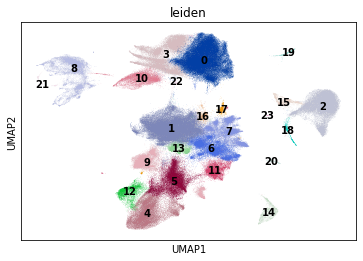

In [24]:
sc.pl.umap(adata, color = 'leiden', legend_loc='on data')

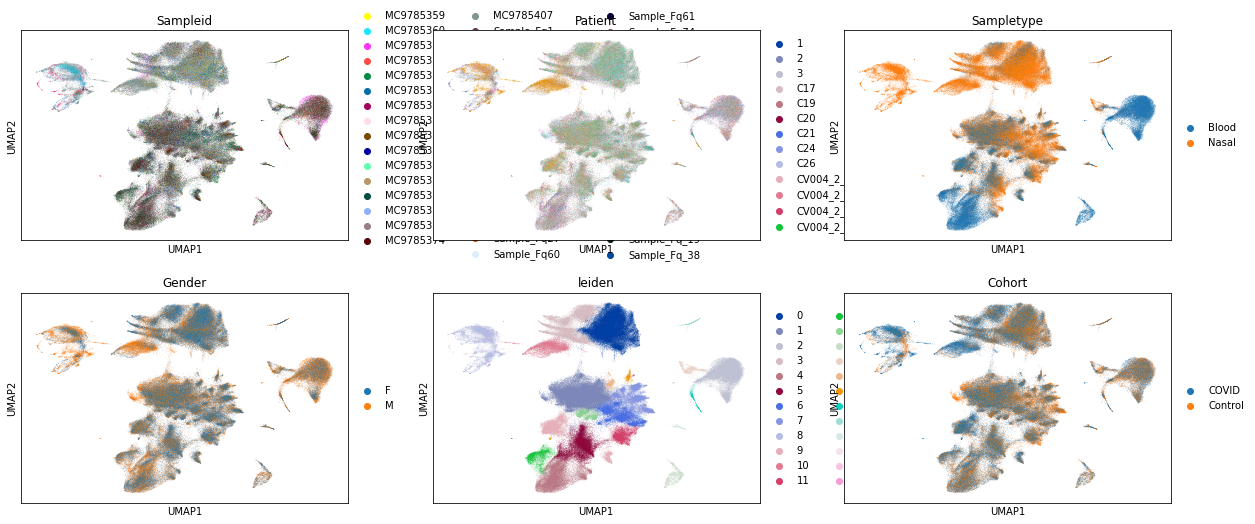

In [25]:
#What is split between meta objects
sc.pl.umap(adata, color=['Sampleid','Patient', 'Sampletype', 'Gender', 'leiden', 'Cohort'], ncols = 3)

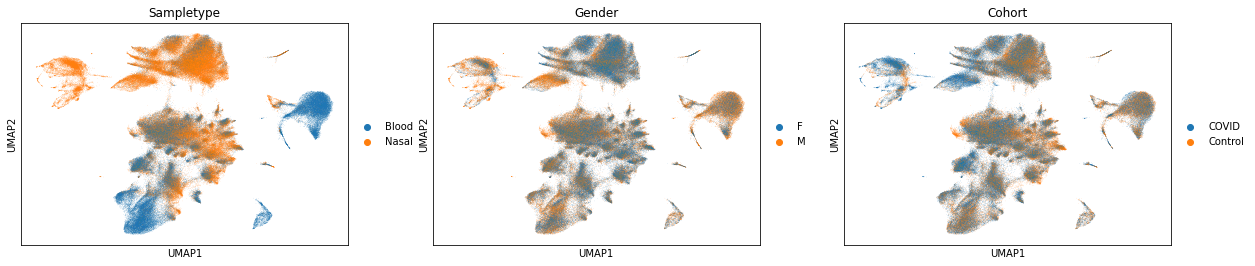

In [26]:
sc.pl.umap(adata, color=['Sampletype', 'Gender', 'Cohort'], ncols = 3)

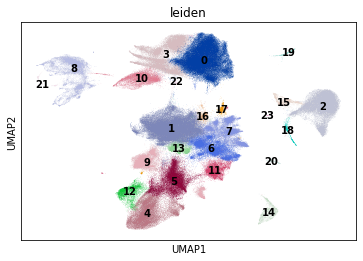

In [41]:
sc.pl.umap(adata, color=['leiden'], legend_loc = 'on data', ncols = 3)

In [27]:
# create a palette for umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)

In [28]:
# run marker gene test
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = 'wilcoxon', n_genes = 30000)

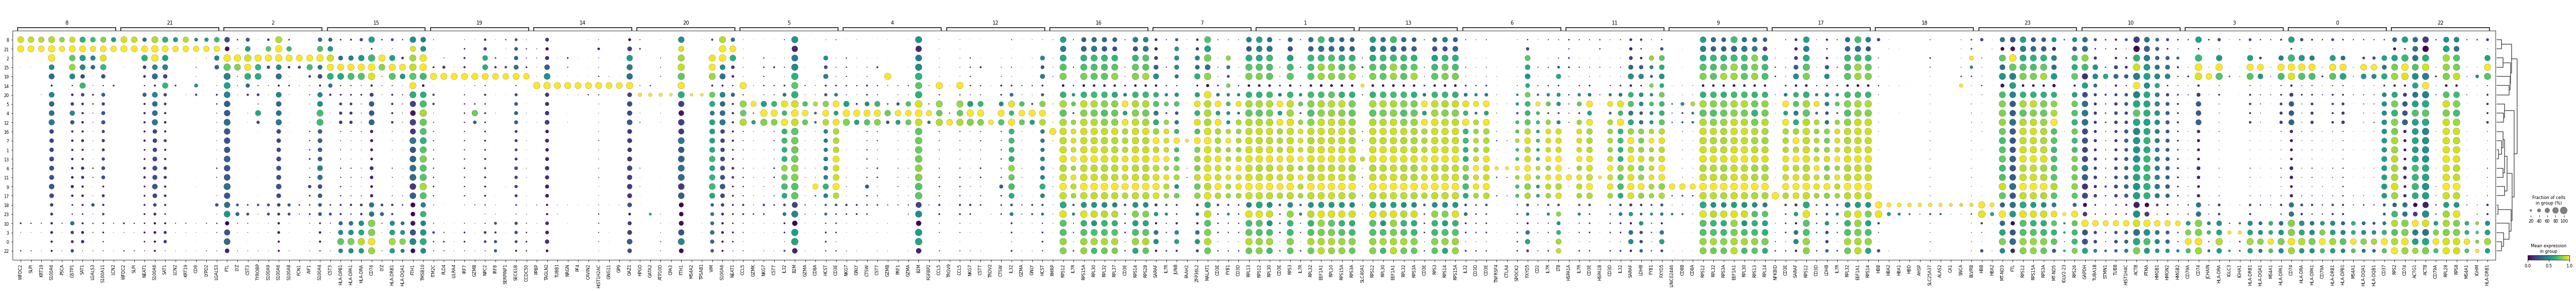

In [29]:
#Dotplot of top 10 DEG by cluster 
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 10, standard_scale = 'var', color_map = 'viridis')

In [30]:
#cluster labels from Chua et al. Nat Biotech 2020
Chuafeat = ['TP63', 'KRT5', 'S100A2', 'FABP5', 'SERPINB3', 'TMSB4X', 'IFIT1', 'IFIT2', 'IFITM3', 'ISG15', 'ISG20', 'OAS1', 'SCGB1A1', 'SCGB3A1', 'XBP1', 'VMO1', 'MUC5AC', 'PIGR', 'FOXN4', 'CCNO', 'MYCL', 'CDC20B', 'TUBA1B', 'PCM1', 'FOXJ1', 'EFHC1', 'CCDC153', 
              'CCDC113', 'MLF1', 'LZTFL1', 'FOXI1', 'CFTR', 'ASCL3', 'FOXI2', 'SFTPB', 'ANK2', 'SFTPB', 'ANK2', 'SPRR1A', 'SPRR2A', 'SPRR2D', 'SPRR2E', 'SPRR3', 'TMPRSS11E', 'IL1B', 'VCAN', 'CD14', 'CCL2', 'FCGR3A', 'CXCL10', 'IFIT1', 'CD68', 'FABP5', 'FCER1A', 'CD74', 'HLA-DQB1',
              'HLA-DRA', 'JCHAIN', 'APOE', 'NCAM1', 'HMGB2', 'STMN1', 'FOXP3', 'CTLA4', 'TNFRSF18', 'CD4', 'CD8B', 'CD8A', 'PRF1', 'GZMA', 'GZMB', 'GNLY', 'NKG7', 'CD3G', 'CD3E', 'KLRB1', 'IL32', 'S100A4', 'CD27', 'CD19', 'MS4A1', 'CD79A', 'IRF7', 'TLR7', 'CLEC4C', 'IL3RA', 'LYN', 
              'FCGR3B', 'ITGAX', 'HPGD', 'LTC4S', 'CPA3','CD69', 'ITGA1', 'KIT', 'HBB', 'PPBP']
Chuafeat

['TP63',
 'KRT5',
 'S100A2',
 'FABP5',
 'SERPINB3',
 'TMSB4X',
 'IFIT1',
 'IFIT2',
 'IFITM3',
 'ISG15',
 'ISG20',
 'OAS1',
 'SCGB1A1',
 'SCGB3A1',
 'XBP1',
 'VMO1',
 'MUC5AC',
 'PIGR',
 'FOXN4',
 'CCNO',
 'MYCL',
 'CDC20B',
 'TUBA1B',
 'PCM1',
 'FOXJ1',
 'EFHC1',
 'CCDC153',
 'CCDC113',
 'MLF1',
 'LZTFL1',
 'FOXI1',
 'CFTR',
 'ASCL3',
 'FOXI2',
 'SFTPB',
 'ANK2',
 'SFTPB',
 'ANK2',
 'SPRR1A',
 'SPRR2A',
 'SPRR2D',
 'SPRR2E',
 'SPRR3',
 'TMPRSS11E',
 'IL1B',
 'VCAN',
 'CD14',
 'CCL2',
 'FCGR3A',
 'CXCL10',
 'IFIT1',
 'CD68',
 'FABP5',
 'FCER1A',
 'CD74',
 'HLA-DQB1',
 'HLA-DRA',
 'JCHAIN',
 'APOE',
 'NCAM1',
 'HMGB2',
 'STMN1',
 'FOXP3',
 'CTLA4',
 'TNFRSF18',
 'CD4',
 'CD8B',
 'CD8A',
 'PRF1',
 'GZMA',
 'GZMB',
 'GNLY',
 'NKG7',
 'CD3G',
 'CD3E',
 'KLRB1',
 'IL32',
 'S100A4',
 'CD27',
 'CD19',
 'MS4A1',
 'CD79A',
 'IRF7',
 'TLR7',
 'CLEC4C',
 'IL3RA',
 'LYN',
 'FCGR3B',
 'ITGAX',
 'HPGD',
 'LTC4S',
 'CPA3',
 'CD69',
 'ITGA1',
 'KIT',
 'HBB',
 'PPBP']

In [31]:
#Marker genes for celltypes from Travaglini 2020 nature lung
Trav_list = ['FOXJ1','KRT5','MUC5B',
   'MUC5B',
   'PRR4',
   'CFTR',
   'CALCA',
   'DCLK1',
   'AGER',
   'SFTPB',
   'ACKR1',
   'CA4',
   'PROX1',
   'CNN1',
   'CNN1',
   'COL1A1',
   'COL1A1',
   'COL1A1',
   'CSPG4',
   'MSLN',
   'SNAP25',
   'CD79A',
   'CD79A',
   'CD3E',
   'CD3E',
   'CD3E',
   'CD3E',
   'KLRD1',
   'CD3E',
   'S100A8',
   'MS4A2',
   'MS4A2',
   'SIGLEC8',
   'NRGN',
   'MARCO',
   'LILRB4',
   'CLEC9A',
   'CD14',
  'SCGB3A2',
   'TUBB1',
   'KRT14',
   'MUC5AC',
   'LPO',
   'FOXI1',
   'CHGA',
   'ASCL2',
   'PDPN',
   'BMX',
   'PDPN',
   'ACTA2',
   'PDGFRA',
   'TRPC6',
   'UPK3B',
   'CD24',
   'CD27',
   'CD8A',
   'CD4',
   'NKG7',
   'CD8B',
   'S100A9',
   'CPA3',
   'PPBP',
   'MSR1',
   'IRF8',
   'LAMP3',
   'CD1C',
   'S100A8',
   'TP73',
   'TP63',
   'SPDEF',
   'LTF',
   'ASCL3',
   'ASCL1',
   'CLIC5',
   'TAGLN',
   'ELN',
   'PLIN2',
   'PDGFRB',
   'MS4A1',
   'SLAMF7',
   'GZMK',
   'COTL1',
   'CCR7',
   'TYROBP',
   'FCER1G',
   'IFITM2',
   'TPSAB1',
   'PF4',
   'MRC1',
   'LILRA4',
   'PLD4',
   'FCGR3A',
   'CCDC78',
   'DAPL1',
   'MUC1',
   'RGS5',
   'DES',
   'ACTA2',
   'APOE',
   'CD19',
   'DUSP2',
   'GZMB',
   'LDHB',
   'LEF1',
   'TYROBP',
   'FCGR3B',
   'OST4',
   'ETV5', 
   'LGR6']
Trav_list

['FOXJ1',
 'KRT5',
 'MUC5B',
 'MUC5B',
 'PRR4',
 'CFTR',
 'CALCA',
 'DCLK1',
 'AGER',
 'SFTPB',
 'ACKR1',
 'CA4',
 'PROX1',
 'CNN1',
 'CNN1',
 'COL1A1',
 'COL1A1',
 'COL1A1',
 'CSPG4',
 'MSLN',
 'SNAP25',
 'CD79A',
 'CD79A',
 'CD3E',
 'CD3E',
 'CD3E',
 'CD3E',
 'KLRD1',
 'CD3E',
 'S100A8',
 'MS4A2',
 'MS4A2',
 'SIGLEC8',
 'NRGN',
 'MARCO',
 'LILRB4',
 'CLEC9A',
 'CD14',
 'SCGB3A2',
 'TUBB1',
 'KRT14',
 'MUC5AC',
 'LPO',
 'FOXI1',
 'CHGA',
 'ASCL2',
 'PDPN',
 'BMX',
 'PDPN',
 'ACTA2',
 'PDGFRA',
 'TRPC6',
 'UPK3B',
 'CD24',
 'CD27',
 'CD8A',
 'CD4',
 'NKG7',
 'CD8B',
 'S100A9',
 'CPA3',
 'PPBP',
 'MSR1',
 'IRF8',
 'LAMP3',
 'CD1C',
 'S100A8',
 'TP73',
 'TP63',
 'SPDEF',
 'LTF',
 'ASCL3',
 'ASCL1',
 'CLIC5',
 'TAGLN',
 'ELN',
 'PLIN2',
 'PDGFRB',
 'MS4A1',
 'SLAMF7',
 'GZMK',
 'COTL1',
 'CCR7',
 'TYROBP',
 'FCER1G',
 'IFITM2',
 'TPSAB1',
 'PF4',
 'MRC1',
 'LILRA4',
 'PLD4',
 'FCGR3A',
 'CCDC78',
 'DAPL1',
 'MUC1',
 'RGS5',
 'DES',
 'ACTA2',
 'APOE',
 'CD19',
 'DUSP2',
 'GZMB',
 'LDHB',
 

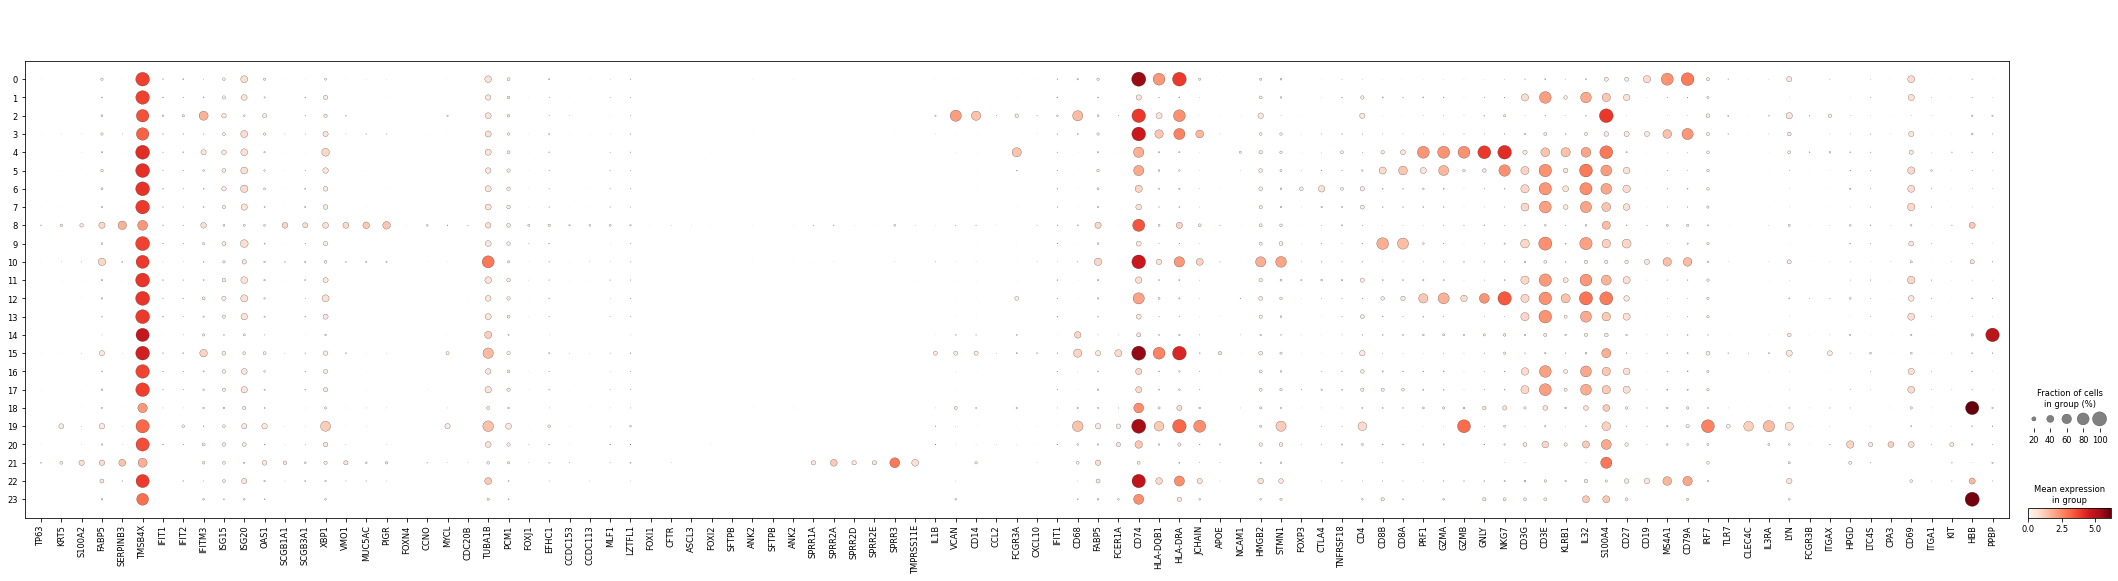

In [32]:
#Chua marker gene expression by cluster 
sc.pl.dotplot(adata, Chuafeat, groupby = 'leiden')

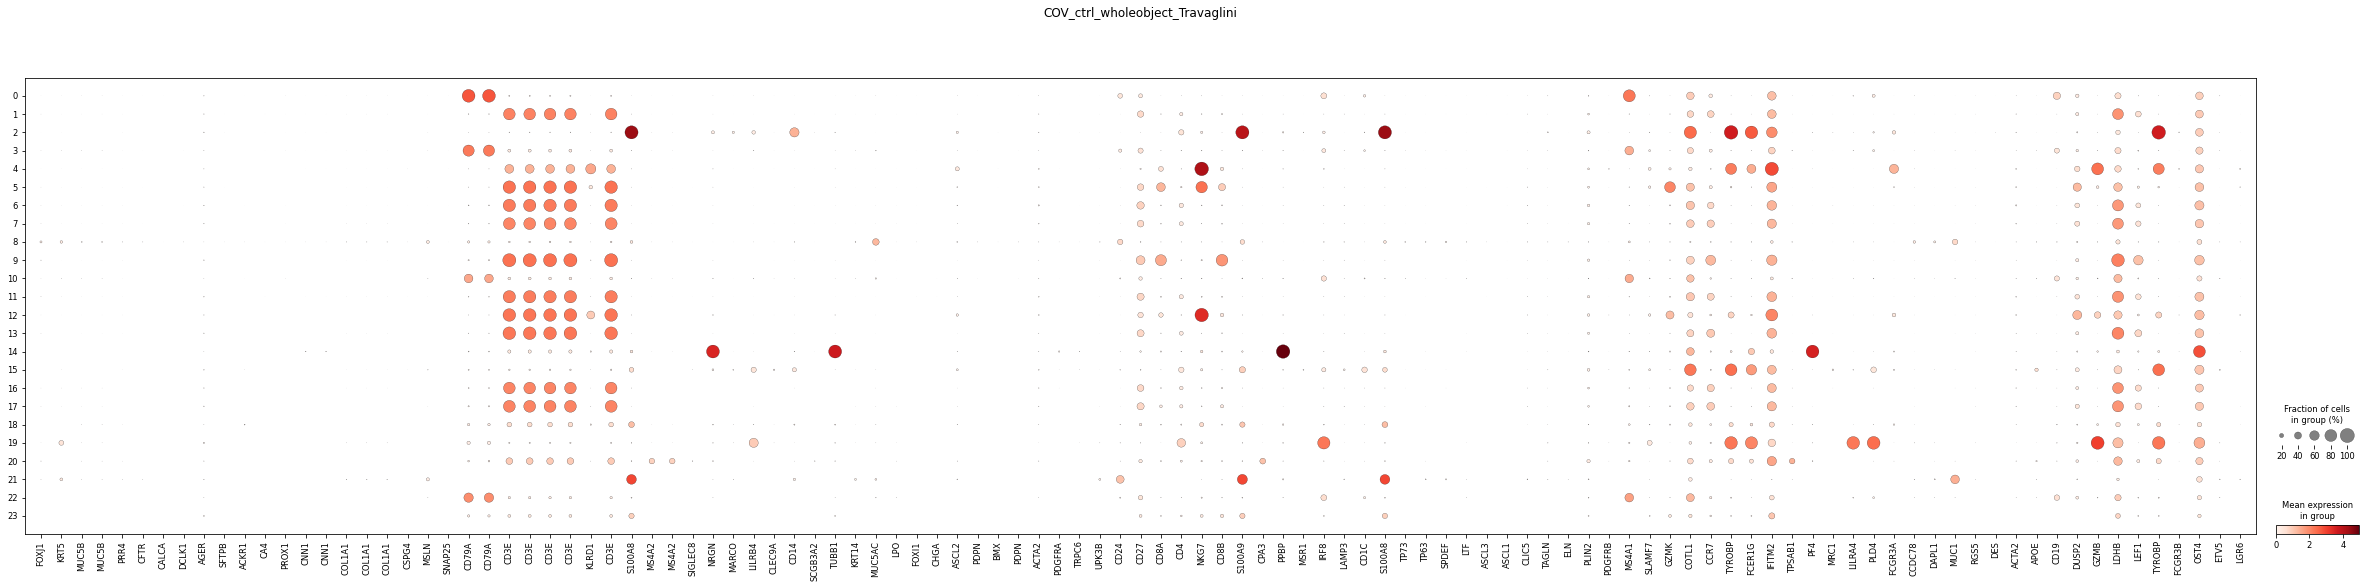

In [33]:
#Travalini marker genes by cluster
sc.pl.dotplot(adata,Trav_list, groupby = 'leiden', title = 'COV_ctrl_wholeobject_Travaglini')

In [34]:
ILC_Bjorkland = ['CCL3',
'CXCR3',
'IFNG',
'IL12RB1',
'TBX21',
'PTGDR2',
'IL17RB',
'IL1RL1',
'IL13',
'GATA3',
'NCR2',
'IL22',
'RORC',
'AHR',
'IL23R',
'IL1R1',
'EOMES',
'GZMA',
'GNLY',
'KLRC1']

In [35]:
ILC_Bjorkland

['CCL3',
 'CXCR3',
 'IFNG',
 'IL12RB1',
 'TBX21',
 'PTGDR2',
 'IL17RB',
 'IL1RL1',
 'IL13',
 'GATA3',
 'NCR2',
 'IL22',
 'RORC',
 'AHR',
 'IL23R',
 'IL1R1',
 'EOMES',
 'GZMA',
 'GNLY',
 'KLRC1']

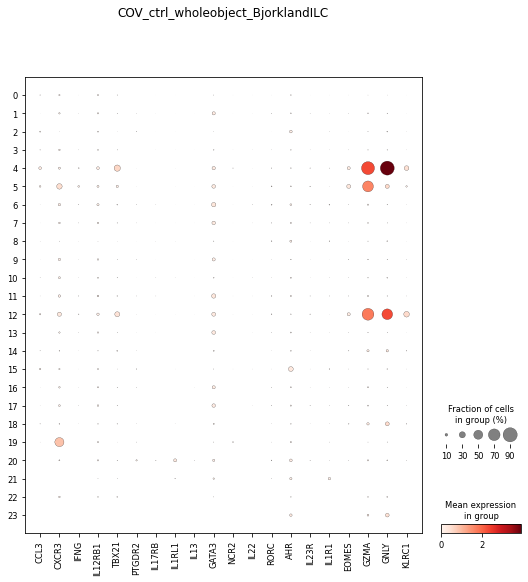

In [36]:
#Bjorkland 2016 Nature immunology 
sc.pl.dotplot(adata,ILC_Bjorkland, groupby = 'leiden', title = 'COV_ctrl_wholeobject_BjorklandILC')

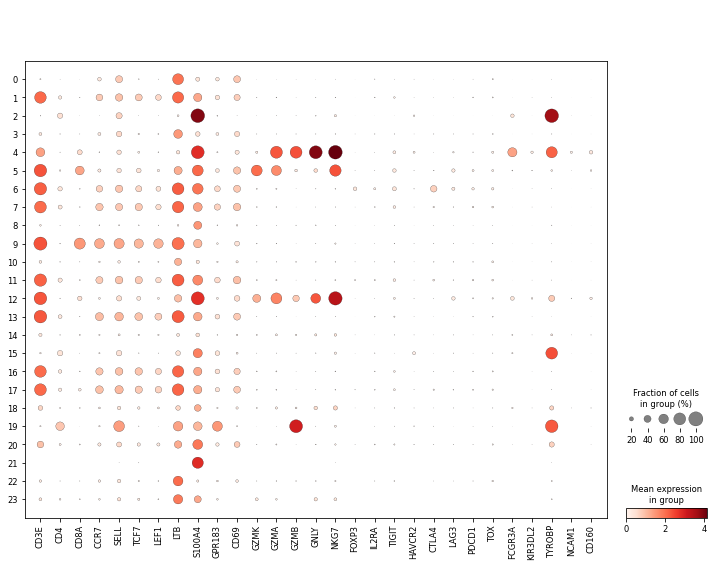

In [38]:
#Zhang 2020 nature immunology t cell subsets single cell markers 
sc.pl.dotplot(adata, Zhang2020_T, groupby = 'leiden')

In [56]:
#Collection of key marker genes for each broad cell cluster
clustermark = ['CD3E', 'CD19', 'JCHAIN','CD4','CD8B','NCAM1','TRDC','FCGR3B','KIT',
               'GATA2','CD68',
              'GZMK','GZMA','GZMB','CCR7','SELL','FOXP3','EPCAM','MUC5AC','HBB','PPBP',
              'HLA-DRA','CLEC10A','CLEC4C']

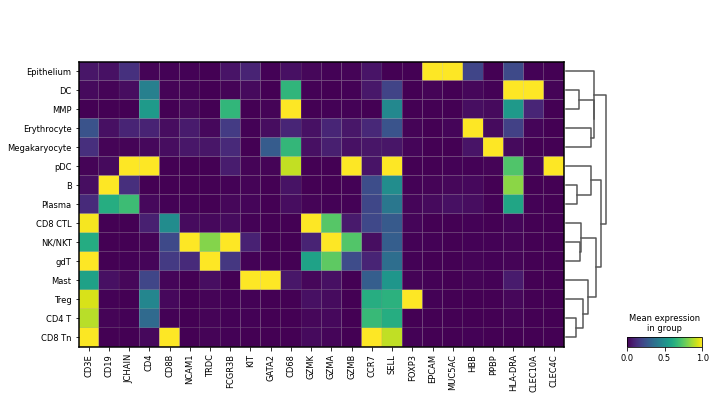

In [61]:
#Plotted as matrixplot with scaling 
sc.pl.matrixplot(adata, clustermark, groupby = 'broad_label',dendrogram = True, standard_scale ='var')

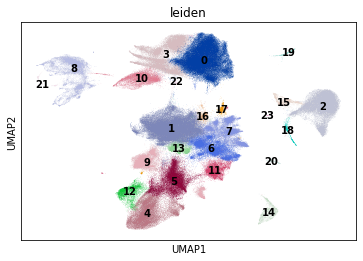

In [40]:
sc.pl.umap(adata,color = 'leiden', legend_loc = 'on data')

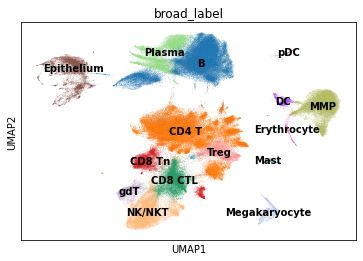

In [42]:
sc.pl.umap(adata,color = 'broad_label', legend_loc = 'on data')

... storing 'broad_label' as categorical


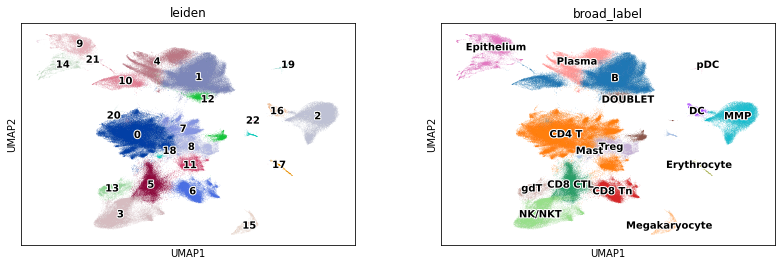

In [72]:
# give broad annotations based on gene expression profiles 
#new_dict = {'0':'B',
           '1':'CD4 T',
           '2':'MMP',
           '3':'Plasma',
           '4':'NK',
           '5':'CD8 CTL',
           '6':'Treg',
           '7':'CD4 T',
           '8':'Epithelial',
           '9':'CD8 Tn',
           '10':'Plasma',
           '11':'CD4 T',
           '12':'gdT',
           '13':'CD4 T',
           '14':'Megakaryocyte',
           '15':'cDC',
           '16':'CD4 T',
           '17':'CD4 T',
           '18':'?DOUBLET',
           '19':'pDC',
           '20':'Mast',
           '21':'Epithelial',
           '22':'B',
           '23':'Erythrocyte'}
#adata.obs['broad_label'] = [new_dict[l] for l in adata.obs['leiden']]
#sc.pl.umap(adata, color=['leiden', 'broad_label'], legend_fontoutline=2, legend_loc = 'on data')

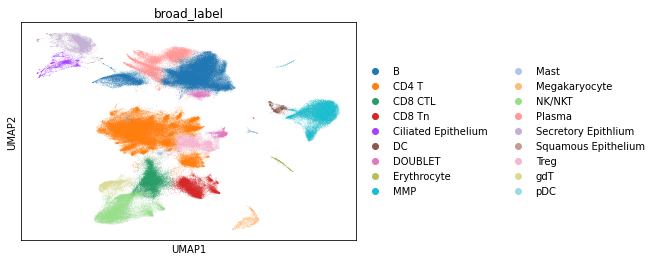

In [57]:
sc.pl.umap(adata, color = 'broad_label')

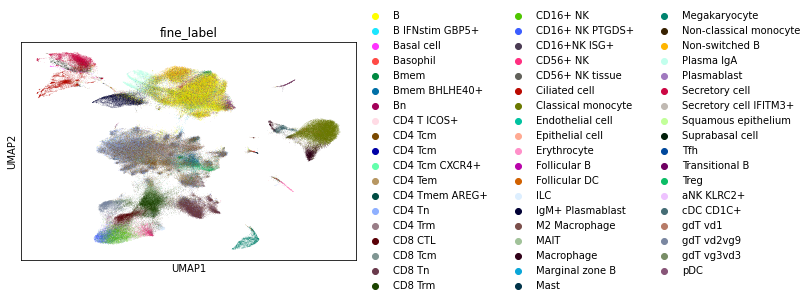

In [73]:
sc.pl.umap(adata, color = 'fine_label')

In [76]:
#What is split of cells across data? 
pd.crosstab(adata.obs['Patient'],adata.obs['broad_label'])

broad_label,B,CD4 T,CD8 CTL,CD8 Tn,DC,DOUBLET,Epithelium,Erythrocyte,MMP,Mast,Megakaryocyte,NK/NKT,Plasma,Treg,gdT,pDC
Patient,,,,,,,,,,,,,,,,
1,1188,613,176,17,14,35,28,3,332,2,0,269,316,38,15,4
2,536,2082,801,174,58,37,1298,13,1325,11,6,2169,137,146,106,9
3,3506,5657,1643,940,86,214,98,170,1004,65,185,1100,969,518,260,47
C17,3389,11713,882,1044,254,775,133,30,568,76,68,869,650,1341,564,68
C19,2982,3205,1129,238,89,175,9,12,856,39,78,1139,955,787,97,92
C20,1155,1924,737,847,72,116,24,71,450,41,107,1535,344,251,307,30
C21,1507,2992,770,218,144,134,168,42,1374,25,27,1768,796,378,98,31
C24,1089,844,269,85,157,101,492,108,2042,11,283,671,320,117,36,48
C26,3087,3002,325,131,23,197,20,9,27,22,9,108,1069,518,13,78


In [113]:
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,doublet_score,predicted_doublet,Sampleid,Patient,Sampletype,Age_group,Gender,...,total_counts,total_counts_mt,pct_counts_mt,celltypist,combined_doublet,cellbender_cell,leiden,broad_label,fine_label,moderate-severe
CGCTTCACAAGAAGAG-1-0-0,9.639492,1.0,59.972996,0.094288,False,Sample_Fq21,N01-001,Nasal,middle,M,...,14877.0,234.0,1.572898,Plasmablasts,False,True,10,B,IgM+ Plasmablast,No
GGACATTCATAGACTC-1-0-0,5.833257,1.0,1614.982300,0.127863,False,Sample_Fq21,N01-001,Nasal,middle,M,...,14330.0,327.0,2.281926,Plasmablasts,False,True,4,Plasma,Plasma IgA,No
GCACATAGTAAGGATT-1-0-0,8.461997,1.0,256.971954,0.082260,False,Sample_Fq21,N01-001,Nasal,middle,M,...,13576.0,270.0,1.988804,Plasmablasts,False,True,4,Plasma,Plasma IgA,No
GACGTGCTCGTAGATC-1-0-0,8.653172,1.0,67.775795,0.152305,False,Sample_Fq21,N01-001,Nasal,middle,M,...,12963.0,85.0,0.655712,Plasmablasts,False,True,4,Plasma,Plasma IgA,No
CTCTGGTAGTACGTAA-1-0-0,7.128809,1.0,47.314678,0.116067,False,Sample_Fq21,N01-001,Nasal,middle,M,...,10814.0,64.0,0.591825,Plasmablasts,False,True,4,Plasma,Plasma IgA,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCCTCTTG-1-7-1,NaN,NaN,NaN,NaN,nan,Sample_Fq_9,C19,Nasal,Old,F,...,2012.0,100.0,4.970179,Naive B cells,False,False,4,Plasma,Non-switched B,No
TTTGTCAGTCTAGGTT-1-7-1,NaN,NaN,NaN,NaN,nan,Sample_Fq_9,C19,Nasal,Old,F,...,2007.0,80.0,3.986049,Regulatory T cells,False,False,0,CD4 T,CD4 Tem,No
TTTGTCAGTGGTAACG-1-7-1,NaN,NaN,NaN,NaN,nan,Sample_Fq_9,C19,Nasal,Old,F,...,3979.0,189.0,4.749938,pDC,False,False,19,pDC,pDC,No
TTTGTCAGTTGCGTTA-1-7-1,NaN,NaN,NaN,NaN,nan,Sample_Fq_9,C19,Nasal,Old,F,...,1978.0,93.0,4.701719,Naive B cells,False,False,1,B,B,No


In [63]:
#add Mark's missing metadata
adata.obs['Gender'][adata.obs['Patient'] == 'N01-001'] = 'M'

In [65]:
#add missing metadata
adata.obs['Gender'][adata.obs['Patient'] == 'N01-002'] = 'F'

In [66]:
#add missing metadata
adata.obs['Gender'][adata.obs['Patient'] == 'N01-005'] = 'M'

In [67]:
#add missing metadata
adata.obs['Gender'][adata.obs['Patient'] == 'N01-011'] = 'M'

In [68]:
adata.obs['Gender'].value_counts()

M    157879
F    140010
Name: Gender, dtype: int64

In [78]:
adata

AnnData object with n_obs × n_vars = 297889 × 1413
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'doublet_score', 'predicted_doublet', 'Sampleid', 'Patient', 'Sampletype', 'Age_group', 'Gender', 'Cohort', 'Diseasetype', 'Batch', 'Study', 'Nasal_inflammation', 'COVID_severity', 'sampleid', 'soup_correction', 'scrublet_score', 'n_genes', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltypist', 'combined_doublet', 'cellbender_cell', 'leiden', 'broad_label', 'fine_label'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'Sampleid_colors', 'Patient_colors', 'Sampletype_colors', 'leiden', 'Gender_colors', 'leiden_colors', 'Cohort_colors', 'celltypist_colors', 'rank_genes_groups', 'dendro

In [75]:
pd.crosstab(adata.obs['broad_label'], adata.obs['Diseasetype'])

Diseasetype,Active COV,Conval COV,GPA control,Healthy control
broad_label,,,,
B,17037,20072,15644,13209
CD4 T,23249,17685,21596,23680
CD8 CTL,5956,4982,3395,4112
CD8 Tn,4139,6576,2259,2563
DC,363,366,415,739
DOUBLET,1327,1565,1310,1498
Epithelium,5347,4562,3556,846
Erythrocyte,299,294,422,272
MMP,7234,3984,7265,5317


In [79]:
adata.obs['COVID_severity'].value_counts()

mild            87332
mild            40800
severe          19970
moderate         8908
asymptomatic     4045
Name: COVID_severity, dtype: int64

In [86]:
adata.obs['Patient']

CGCTTCACAAGAAGAG-1-0-0    N01-001
GGACATTCATAGACTC-1-0-0    N01-001
GCACATAGTAAGGATT-1-0-0    N01-001
GACGTGCTCGTAGATC-1-0-0    N01-001
CTCTGGTAGTACGTAA-1-0-0    N01-001
                           ...   
TTTGTCAGTCCTCTTG-1-7-1        C19
TTTGTCAGTCTAGGTT-1-7-1        C19
TTTGTCAGTGGTAACG-1-7-1        C19
TTTGTCAGTTGCGTTA-1-7-1        C19
TTTGTCATCAACCAAC-1-7-1        C19
Name: Patient, Length: 297889, dtype: category
Categories (25, object): ['1', '2', '3', 'C17', ..., 'N01-002', 'N01-005', 'N01-011', 'N01-022']

In [88]:
# Create new 'moderate-severe covid' variable and add to metadata. 
new_dict = {'IRVAS_39':'No',
            'IRVAS_44':'No',
            'N01-001':'No',
            'N01-002':'No',
            'N01-005':'No',
          'N01-011':'No',
           'N01-022':'No',
           '1':'Yes',
           '2':'Yes',
           '3':'No',
           'C20':'No',
           'C19':'No',
           'C24':'No',
           'C21':'No',
           'C17':'No',
           'C26':'No',
           'CV004_2_4':'Yes',
           'CV004_2_5':'Yes',
           'CV004_2_6':'No',
           'CV004_2_7':'No',
           'CV004_2_8':'No',
           'CV004_2_9':'No',
           'CV004_2_10':'No',
           'CV004_2_11':'No',
           'CV004_2_12':'No'}
adata.obs['moderate-severe'] = [new_dict[l] for l in adata.obs['Patient']]
adata.obs['moderate-severe'].value_counts()

No     269011
Yes     28878
Name: moderate-severe, dtype: int64

In [89]:
#Check 
pd.crosstab(adata.obs['broad_label'],adata.obs['moderate-severe'])

moderate-severe,No,Yes
broad_label,,
B,60854,5108
CD4 T,80305,5905
CD8 CTL,16747,1698
CD8 Tn,15207,330
DC,1741,142
DOUBLET,5399,301
Epithelium,9219,5092
Erythrocyte,1220,67
MMP,19310,4490


In [90]:
pd.crosstab(adata.obs['Patient'],adata.obs['moderate-severe'])

moderate-severe,No,Yes
Patient,,
1,0,3050
2,0,8908
3,16462,0
C17,22424,0
C19,11882,0
C20,8011,0
C21,10472,0
C24,6673,0
C26,8638,0


In [91]:
pd.crosstab(adata.obs['Sampletype'],adata.obs['moderate-severe'])

moderate-severe,No,Yes
Sampletype,,
Blood,103543,11119
Nasal,165468,17759


In [92]:
#Save
adata.write('COV_recluster_nd_broad_label_080721.h5ad', compression = 'gzip')
adata.raw.to_adata().write('COV_recluster_nd_broad_label_080721_raw.h5ad', compression = 'gzip')

... storing 'moderate-severe' as categorical
